In [1]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from scipy.spatial import distance
# from scipy.sparse.csgraph import minimum_spanning_tree
import math
import pickle
import time


## USING PREVIOUS DATA

We want to be able to save thing 

IF Pickled = True then we will previously simulated data using the pickle packge

In [2]:
PICKLED = True 

##### set parent directory

In [3]:
import os

# Get the current working directory
current_directory = os.getcwd()
# print("Current Directory:", current_directory)

# Move to the parent directory
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)

# Print the updated working directory
updated_directory = os.getcwd()
print("Updated Directory:", updated_directory)

Updated Directory: /mnt/c/users/rjmay/code/research_ms


In [4]:
# os.chdir(os.getcwd() + "/code/research_ms")


### Simulation stage

In [5]:
from modules.multi_bounds import bounds_class


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
mean_sep = np.linspace(0, 3,20 , endpoint = True)

# mean_sep = np.insert(mean_sep, 1, .1)
# mean_sep = np.linspace(.05, 3, 2 , endpoint = True)

mean_sep

array([0.        , 0.15789474, 0.31578947, 0.47368421, 0.63157895,
       0.78947368, 0.94736842, 1.10526316, 1.26315789, 1.42105263,
       1.57894737, 1.73684211, 1.89473684, 2.05263158, 2.21052632,
       2.36842105, 2.52631579, 2.68421053, 2.84210526, 3.        ])

In [7]:
bound_obj_lst = []

bound_obj_lst2 = []


if PICKLED: ## We just skip all the data creation if we are using save data. 
    print("USING PREVIOUS DATA NOT SIMULATING DATA ")
else:

    MC_num = 500

    for i in mean_sep:

        start = time.time()

        mean1 = [0, 0, 0, 0, 0 ]
        covariance1 = np.identity(5)
        mean2 = [i, 0, 0, 0, 0  ]
        covariance2= np.identity(5)
        mean1 = np.array(mean1)
        mean2 = np.array(mean2)
        
        tight_params = [4, 3 ]
        
        sample_size= 100
        n0, n1 = sample_size, sample_size
        
        k = int(np.sqrt(sample_size))
        tight_params = [4, k ]

        
        params1  = [mean1, covariance1, n0]
        params2  = [mean2, covariance2, n1]

        bounds = bounds_class("mv_normal", params1, params2, threads =2,  MC_num = MC_num, tight_params = tight_params )
        
        bound_obj_lst.append(bounds)
        
        sample_size= 500
               
        k = int(np.sqrt(sample_size))
        tight_params = [4, k ]
        
        n0, n1 = sample_size, sample_size
        params1  = [mean1, covariance1, n0]
        params2  = [mean2, covariance2, n1]
        
        bounds2 = bounds_class("mv_normal", params1, params2, threads =2,  MC_num = MC_num, tight_params = tight_params )

        bound_obj_lst2.append(bounds2)
        
        
        end = time.time()
        
        print("done with ", i, " in ",  end -start )



USING PREVIOUS DATA NOT SIMULATING DATA 


##### Pickling
This is where the data either gets save or loaded

In [8]:
file_path = 'sim_data/means_sep_as_BER.pkl' # DONT FORGET TO CHANGE ME IF YOU COPY AND PASTE


if PICKLED  == False:
    
    objects_to_save = bound_obj_lst, bound_obj_lst2


    with open(file_path, 'wb') as file:
        # Use pickle.dump to serialize and write the list of objects to the file
        pickle.dump(objects_to_save, file)
    print(f'Objects saved to {file_path}')
    

elif PICKLED == True:
    

    # Open the file in binary read mode
    with open(file_path, 'rb') as file:
        # Use pickle.load to deserialize and load the list of objects from the file
        loaded_objects = pickle.load(file)

    print('Loaded object successfully')
    
    bound_obj_lst, bound_obj_lst2 = loaded_objects

Loaded object successfully


## Using the data

may or not be pickled. 

In [9]:
exact = []

for i in mean_sep:
    dx = 0.001
    x = np.arange(-5, 8 + dx, dx)

    f0 = np.exp(-0.5 * (x - 0)**2) / np.sqrt(2 * np.pi)
    f1 = np.exp(-0.5 * (x - i)**2) / np.sqrt(2 * np.pi)

    fmin = np.minimum(f0, f1)

    BER = 0.5 * np.sum(fmin * dx)
    
    exact.append(BER)

#     print("BER 2d:", BER)

### Plotting using sample size 100

In [10]:
dp_l = []
dp_u = []

Bha_u =[]
Bha_l =[]

tight_l = []
tight_u = []

for obj in bound_obj_lst:
    a,b = obj.get_bounds_dp()
    dp_l.append(np.mean(a))
    dp_u.append(np.mean(b))
    
    a,b = obj.get_bounds_Bha()
    Bha_l.append(np.mean(a))
    Bha_u.append(np.mean(b))
    
    a, b = obj.get_bounds_tight()
    tight_l.append(np.mean(a))
    tight_u.append(np.mean(b))

    
    

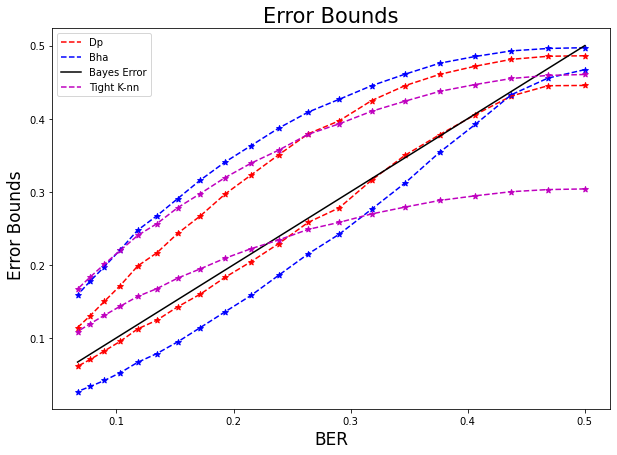

In [11]:
fs =17
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)


ax.plot(exact, dp_l, 'r--', label='Dp')
ax.plot(exact, dp_u, 'r--')

ax.scatter(exact, dp_l, color='r', marker='*')
ax.scatter(exact, dp_u, color ='r', marker ='*' )

ax.plot(exact, Bha_l, 'b--', label='Bha')
ax.plot(exact, Bha_u, 'b--')
ax.scatter(exact, Bha_u, color='b', marker='*')
ax.scatter(exact, Bha_l, color ='b', marker ='*' )


ax.plot(exact, exact, 'k', label='Bayes Error')

ax.plot(exact, tight_l, 'm--', label='Tight K-nn')
ax.plot(exact, tight_u, 'm--')
ax.scatter(exact, tight_l, color='m', marker='*')
ax.scatter(exact, tight_u, color ='m', marker ='*' )


ax.set_xlabel("BER", fontsize = fs)
ax.set_ylabel("Error Bounds  ", fontsize=fs)
ax.set_title("Error Bounds", fontsize = fs +4)
ax.legend()
# plt.savefig("bounds.png",facecolor=(1,1,1,1))

plt.show()


In [12]:
validity_dp_l = np.zeros(len(mean_sep))
validity_dp_u = np.zeros(len(mean_sep))

validity_Bha_l = np.zeros(len(mean_sep))
validity_Bha_u =  np.zeros(len(mean_sep))

validity_tight_l = np.zeros(len(mean_sep))
validity_tight_u =  np.zeros(len(mean_sep))

MC_num = bound_obj_lst[0].get_MC_num()


for i in range(len(mean_sep)):
    BER = exact[i]
    Bha_l_temp, Bha_u_temp = bound_obj_lst[i].get_bounds_Bha()
    dp_l_temp, dp_u_temp = bound_obj_lst[i].get_bounds_dp()
    tight_l_temp, tight_u_temp = bound_obj_lst[i].get_bounds_tight()
    for j in range(MC_num):
        if Bha_l_temp[j] < BER:
            validity_Bha_l[i] += 1
        if Bha_u_temp[j] > BER:
            validity_Bha_u[i] += 1
    
        if dp_l_temp[j] < BER:
            validity_dp_l[i] += 1
        if dp_u_temp[j] > BER:
            validity_dp_u[i] += 1
        if tight_l_temp[j] < BER:
            validity_tight_l[i] += 1
        if tight_u_temp[j]> BER:
            validity_tight_u[i] += 1


In [13]:
print(validity_dp_l,  validity_dp_u, validity_Bha_l, validity_Bha_u, validity_tight_l, validity_tight_u )

[241. 239. 256. 274. 261. 282. 281. 317. 292. 301. 336. 329. 331. 333.
 333. 300. 344. 327. 339. 323.] [259. 407. 473. 488. 498. 494. 499. 499. 500. 498. 500. 498. 498. 495.
 497. 498. 495. 490. 489. 481.] [238. 272. 282. 336. 365. 408. 438. 465. 473. 483. 490. 496. 494. 497.
 499. 498. 500. 499. 500. 500.] [262. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500.] [500. 500. 500. 500. 500. 500. 500. 495. 434. 309. 168.  74.  39.  13.
  12.   3.   1.   0.   0.   0.] [  0.  67. 470. 498. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500.]


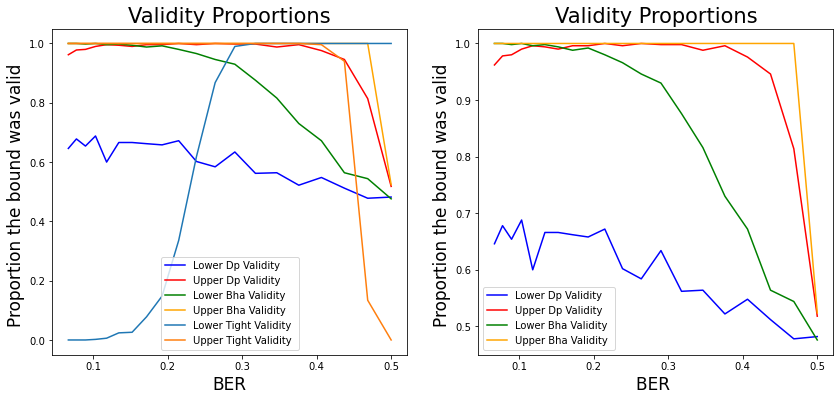

In [14]:
fs =17

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

ax = axes[0]

# ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)

ax.plot(exact, validity_dp_l/ MC_num, 'b',  label='Lower Dp Validity ')
ax.plot(exact, validity_dp_u/ MC_num, 'r', label='Upper Dp Validity ')

ax.plot(exact, validity_Bha_l/ MC_num,'g', label='Lower Bha Validity ')
ax.plot(exact, validity_Bha_u/ MC_num, 'orange', label='Upper Bha Validity ')


ax.plot(exact, validity_tight_l/ MC_num, label='Lower Tight Validity ')
ax.plot(exact, validity_tight_u/ MC_num,  label='Upper Tight Validity ')

ax.set_xlabel("BER", fontsize = fs)
ax.set_ylabel("Proportion the bound was valid ", fontsize=fs)
ax.set_title("Validity Proportions" , fontsize = fs +4)
ax.legend()



ax = axes[1]

# ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)

ax.plot(exact, validity_dp_l/ MC_num, 'b',  label='Lower Dp Validity ')
ax.plot(exact, validity_dp_u/ MC_num, 'r', label='Upper Dp Validity ')

ax.plot(exact, validity_Bha_l/ MC_num,'g', label='Lower Bha Validity ')
ax.plot(exact, validity_Bha_u/ MC_num, 'orange', label='Upper Bha Validity ')


# ax.plot(exact, validity_tight_l/ MC_num, label='Lower Tight Validity ')
# ax.plot(exact, validity_tight_u/ MC_num,  label='Upper Tight Validity ')
# # ax.set_xticks(sample_sizes)


ax.set_xlabel("BER ", fontsize = fs)
ax.set_ylabel("Proportion the bound was valid ", fontsize=fs)
ax.set_title("Validity Proportions" , fontsize = fs +4)
ax.legend()


# plt.savefig("proportions.png",facecolor=(1,1,1,1))
plt.show()

### Plotting using sample size 500

In [15]:
dp_l = []
dp_u = []

Bha_u =[]
Bha_l =[]

tight_l = []
tight_u = []

for obj in bound_obj_lst2:
    a,b = obj.get_bounds_dp()
    dp_l.append(np.mean(a))
    dp_u.append(np.mean(b))
    
    a,b = obj.get_bounds_Bha()
    Bha_l.append(np.mean(a))
    Bha_u.append(np.mean(b))
    
    a, b = obj.get_bounds_tight()
    tight_l.append(np.mean(a))
    tight_u.append(np.mean(b))

    

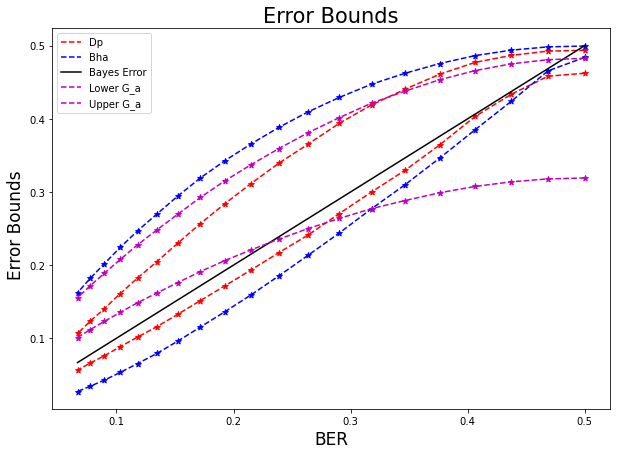

In [16]:
fs =17
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)


ax.plot(exact, dp_l, 'r--', label='Dp')
ax.plot(exact, dp_u, 'r--')

ax.scatter(exact, dp_l, color='r', marker='*')
ax.scatter(exact, dp_u, color ='r', marker ='*' )

ax.plot(exact, Bha_l, 'b--', label='Bha')
ax.plot(exact, Bha_u, 'b--')
ax.scatter(exact, Bha_u, color='b', marker='*')
ax.scatter(exact, Bha_l, color ='b', marker ='*' )


ax.plot(exact, exact, 'k', label='Bayes Error')

ax.plot(exact, tight_l, 'm--', label='Lower G_a')
ax.plot(exact, tight_u, 'm--', label='Upper G_a')
ax.scatter(exact, tight_l, color='m', marker='*')
ax.scatter(exact, tight_u, color ='m', marker ='*' )

# ax.set_xticks(np.linspace(0,.5, 6))

ax.set_xlabel("BER", fontsize = fs)
ax.set_ylabel("Error Bounds  ", fontsize=fs)
ax.set_title("Error Bounds", fontsize = fs +4)
ax.legend()
# plt.savefig("bounds.png",facecolor=(1,1,1,1))

plt.show()


In [17]:
validity_dp_l = np.zeros(len(mean_sep))
validity_dp_u = np.zeros(len(mean_sep))

validity_Bha_l = np.zeros(len(mean_sep))
validity_Bha_u =  np.zeros(len(mean_sep))

validity_tight_l = np.zeros(len(mean_sep))
validity_tight_u =  np.zeros(len(mean_sep))

MC_num = bound_obj_lst[1].get_MC_num()


for i in range(len(mean_sep)):
    BER = exact[i]
    Bha_l_temp, Bha_u_temp = bound_obj_lst2[i].get_bounds_Bha()
    dp_l_temp, dp_u_temp = bound_obj_lst2[i].get_bounds_dp()
    tight_l_temp, tight_u_temp = bound_obj_lst2[i].get_bounds_tight()
    for j in range(MC_num):
        if Bha_l_temp[j] < BER:
            validity_Bha_l[i] += 1
        if Bha_u_temp[j] > BER:
            validity_Bha_u[i] += 1
    
        if dp_l_temp[j] < BER:
            validity_dp_l[i] += 1
        if dp_u_temp[j] > BER:
            validity_dp_u[i] += 1
        if tight_l_temp[j] < BER:
            validity_tight_l[i] += 1
        if tight_u_temp[j]> BER:
            validity_tight_u[i] += 1


In [18]:
# print(validity_dp_l,  validity_dp_u, validity_Bha_l, validity_Bha_u, validity_tight_l, validity_tight_u )

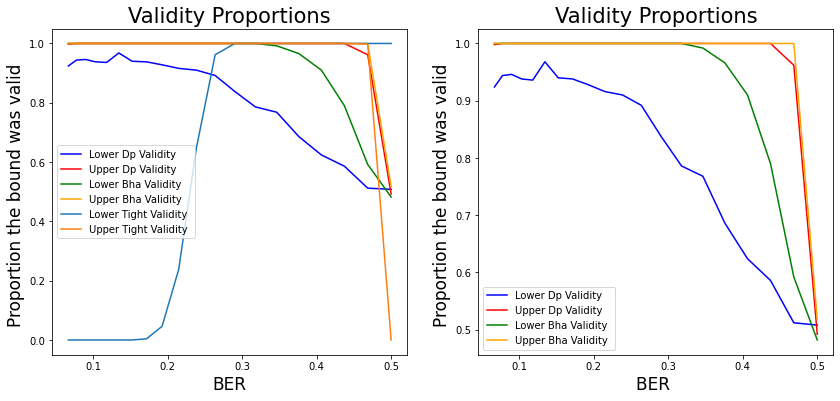

In [19]:
fs =17

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

ax = axes[0]

# ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)

ax.plot(exact, validity_dp_l/ MC_num, 'b',  label='Lower Dp Validity ')
ax.plot(exact, validity_dp_u/ MC_num, 'r', label='Upper Dp Validity ')

ax.plot(exact, validity_Bha_l/ MC_num,'g', label='Lower Bha Validity ')
ax.plot(exact, validity_Bha_u/ MC_num, 'orange', label='Upper Bha Validity ')


ax.plot(exact, validity_tight_l/ MC_num, label='Lower Tight Validity ')
ax.plot(exact, validity_tight_u/ MC_num,  label='Upper Tight Validity ')
# ax.set_xticks(sample_sizes)

ax.set_xlabel("BER", fontsize = fs)
ax.set_ylabel("Proportion the bound was valid ", fontsize=fs)
ax.set_title("Validity Proportions" , fontsize = fs +4)
ax.legend()


ax = axes[1]

# ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)

ax.plot(exact, validity_dp_l/ MC_num, 'b',  label='Lower Dp Validity ')
ax.plot(exact, validity_dp_u/ MC_num, 'r', label='Upper Dp Validity ')

ax.plot(exact, validity_Bha_l/ MC_num,'g', label='Lower Bha Validity ')
ax.plot(exact, validity_Bha_u/ MC_num, 'orange', label='Upper Bha Validity ')


# ax.plot(exact, validity_tight_l/ MC_num, label='Lower Tight Validity ')
# ax.plot(exact, validity_tight_u/ MC_num,  label='Upper Tight Validity ')
# # ax.set_xticks(sample_sizes)


ax.set_xlabel("BER ", fontsize = fs)
ax.set_ylabel("Proportion the bound was valid ", fontsize=fs)
ax.set_title("Validity Proportions" , fontsize = fs +4)
ax.legend()


# plt.savefig("proportions.png",facecolor=(1,1,1,1))
plt.show()